In [1]:
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patheffects import Stroke
from torchvision import transforms
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torch.utils.data import Dataset, Subset
from pycocotools.coco import COCO
import numpy as np
import os
import json
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
from datetime import datetime
from pycocotools import mask as maskUtils
from pycocotools.cocoeval import COCOeval

In [ ]:
# Step 1: Resize Images and Save Them
def resize_images():
    resized_img_dir = './data/resized_images/'
    os.makedirs(resized_img_dir, exist_ok=True)
    
    original_img_dir = './data'
    with open('./data/annotations.json', 'r') as f:
        coco_annotations = json.load(f)
    
    images_info = coco_annotations['images']
    
    for img_info in images_info:
        file_name = img_info['file_name']
        img_path = os.path.join(original_img_dir, file_name)
        
        # Open and resize the image
        img = Image.open(img_path).convert('RGB')
        img_resized = img.resize((640, 640), Image.LANCZOS)
        
        # Save the resized image
        resized_img_path = os.path.join(resized_img_dir, file_name)
        os.makedirs(os.path.dirname(resized_img_path), exist_ok=True)
        img_resized.save(resized_img_path, quality=95)
    
    print("Image resizing completed.")

In [29]:
def update_annotations():
    import json
    from pycocotools import mask as maskUtils
    from PIL import Image
    import numpy as np

    with open('./data/annotations.json', 'r') as f:
        coco_annotations = json.load(f)

    resized_annotations = coco_annotations.copy()
    resized_annotations['images'] = []
    resized_annotations['annotations'] = []

    for img_info in coco_annotations['images']:
        img_id = img_info['id']
        original_width = img_info['width']
        original_height = img_info['height']
        scale_x = 640 / original_width
        scale_y = 640 / original_height

        # Update image info
        img_info_resized = img_info.copy()
        img_info_resized['width'] = 640
        img_info_resized['height'] = 640
        resized_annotations['images'].append(img_info_resized)

        # Update annotations for this image
        anns = [ann for ann in coco_annotations['annotations'] if ann['image_id'] == img_id]
        for ann in anns:
            ann_resized = ann.copy()

            # Update bounding box
            x, y, w, h = ann['bbox']
            x_new = x * scale_x
            y_new = y * scale_y
            w_new = w * scale_x
            h_new = h * scale_y
            ann_resized['bbox'] = [x_new, y_new, w_new, h_new]

            # Update segmentation
            if isinstance(ann['segmentation'], list):
                # Polygon format
                segm_resized = []
                for seg in ann['segmentation']:
                    segm_resized.append([coord * scale_x if i % 2 == 0 else coord * scale_y for i, coord in enumerate(seg)])
                ann_resized['segmentation'] = segm_resized
            else:
                # RLE format
                segm = ann['segmentation']

                if isinstance(segm['counts'], list):
                    # Uncompressed RLE
                    h_segm, w_segm = segm['size']
                    rle = maskUtils.frPyObjects([segm], h_segm, w_segm)
                    mask = maskUtils.decode(rle)
                    mask = mask[:, :, 0]  # Remove extra dimension
                else:
                    # Compressed RLE
                    mask = maskUtils.decode(segm)

                # Resize the mask
                mask_resized = Image.fromarray(mask).resize((640, 640), Image.NEAREST)
                mask_resized = np.array(mask_resized)
                # Encode the resized mask back to RLE
                rle_resized = maskUtils.encode(np.asfortranarray(mask_resized))
                # Convert 'counts' to utf-8 string if necessary
                if isinstance(rle_resized['counts'], bytes):
                    rle_resized['counts'] = rle_resized['counts'].decode('utf-8')
                ann_resized['segmentation'] = rle_resized
                ann_resized['segmentation']['size'] = [640, 640]

            resized_annotations['annotations'].append(ann_resized)

    # Save the updated annotations
    with open('./data/resized_annotations.json', 'w') as f:
        json.dump(resized_annotations, f)

    print("Annotation update completed.")


In [30]:
# Testing Coco image
# initialise COCO API for annotations
coco = COCO('./data/annotations.json')

img_dir = './data/images/'
image_id = 7
img = coco.imgs[image_id]
img

loading annotations into memory...
Done (t=4.50s)
creating index...
index created!


{'id': 7,
 'width': 2000,
 'height': 1333,
 'file_name': 'images/t001/OiaMESWPyh.JPG',
 'license': 0,
 'flickr_url': '',
 'coco_url': '',
 'date_captured': 0,
 'timestamp': '2014:07:14 14:52:17',
 'identity': 't001'}

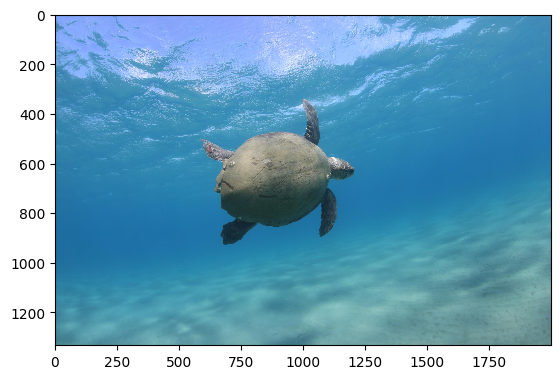

In [31]:
# Load the actual image using the file name in the COCO metadata
image_path = './data/'+ img['file_name']  # Full path to the image
image = np.array(Image.open(image_path))  # Load and convert the image to an array

# Visualize the image
plt.imshow(image, interpolation='nearest')
plt.show()

In [32]:
with open('./data/annotations.json', 'r') as file:
    coco_annotations = json.load(file)

In [33]:
imgs = coco_annotations['images']
# imgs[0]

In [34]:
anns = coco_annotations['annotations']
# anns[1]

In [35]:
# number of images
len(coco_annotations['images'])

8729

In [36]:
coco = COCO('./data/annotations.json')
mask = coco.annToMask(anns[0])
print(mask)

loading annotations into memory...
Done (t=3.26s)
creating index...
index created!
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [37]:
for ann in anns:
  if ann['image_id'] == 1:
    print("what is inside ann in this for loop")
    print(ann)

what is inside ann in this for loop
{'id': 1, 'image_id': 1, 'category_id': 3, 'segmentation': {'counts': [858927, 7, 1322, 23, 1306, 34, 1298, 36, 1296, 39, 1292, 42, 1291, 43, 1289, 45, 1287, 47, 1285, 48, 1285, 49, 1283, 51, 1281, 53, 1280, 54, 1278, 56, 1277, 56, 1277, 57, 1275, 58, 1274, 60, 1273, 61, 1272, 61, 1272, 62, 1270, 63, 1269, 64, 1268, 65, 1268, 65, 1268, 66, 1267, 67, 1266, 67, 1265, 68, 1264, 69, 1263, 70, 1263, 70, 1263, 70, 1263, 70, 1263, 70, 1263, 70, 1262, 71, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1261, 72, 1260, 73, 1260, 73, 1260, 73, 1259, 74, 1258, 75, 1258, 74, 1259, 73, 1260, 72, 1261, 71, 1262, 69, 1263, 69, 1264, 68, 1265, 66, 1266, 64, 1269, 63, 1269, 61, 1272, 59, 1274, 58, 1275, 55, 1278, 52, 1281, 15, 8, 25, 1285, 12, 16, 17, 1289, 9, 24, 3, 1297, 7, 1327, 4, 1715124], 'size': [1333, 2000]}, 'area': 4065.0, 'bbox': [644.0, 441.0, 70.0, 78.0], 'iscrowd': 1, 'attributes': {'orientation': 'left', 'occluded': False}}
what is inside a

In [38]:
image_id = 1
indivisual_mask = coco.annToMask(anns[image_id])
indivisual_mask
print(np.unique(indivisual_mask))

[0 1]


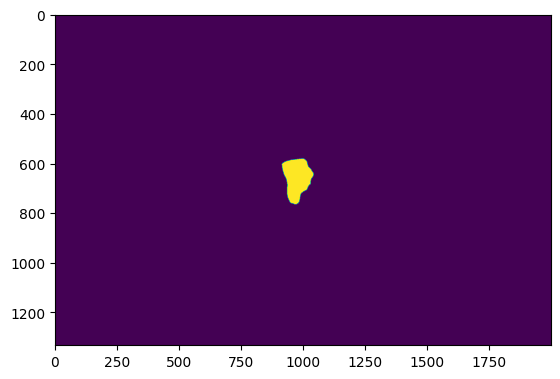

In [39]:
plt.imshow(indivisual_mask)
plt.show()

In [40]:
# Understanding the open split ratio in metadata
meta_split_df = pd. read_csv('./data/metadata_splits.csv')
train_size = 0
val_size = 0
test_size = 0
for i in range(len(meta_split_df['split_open'])):
  if meta_split_df['split_open'][i] == 'train':
    train_size += 1
  elif meta_split_df['split_open'][i] == 'test':
    test_size += 1
  elif meta_split_df['split_open'][i] == 'valid':
    val_size += 1
# meta_split_df['split_open']

print(f'train_size: {train_size}')
print(f'val_size: {val_size}')
print(f'test_size: {test_size}')
total_size = train_size + val_size + test_size

print(f'train ratio: {train_size/total_size}')
print(f'val ratio: {val_size/total_size}')
print(f'test ratio: {test_size/total_size}')

train_size: 5303
val_size: 1118
test_size: 2308
train ratio: 0.6075151792874327
val ratio: 0.12807881773399016
test ratio: 0.26440600297857714


Acutal code begins from here

In [41]:
# ====================== begining of structuring of dataset, maskrcnn model, model training ====================== #

#Dataset structure

class TurtleDataClass(Dataset):
    def __init__(self, img_root_dir, annotation_file_dir, transform=None):
        self.img_root_dir = img_root_dir  # Directory containing images
        self.transform = transform  # Transformations to apply

        # Load the COCO annotations
        with open(annotation_file_dir, 'r') as file:
            self.coco_annotations = json.load(file)  # data = self.coco_annotations in demo

        self.imgs = self.coco_annotations['images']  # List of images (contains all data which will be used to identify the image path)
        self.anns = self.coco_annotations['annotations']  # List of annotations (contains all data which will be used for segmentation)
        # example of anns
        # [{'id': 1,
        # 'image_id': 1,
        # 'category_id': 3,
        # 'segmentation': {'counts': [858927,
        #   7,
        #   'size': [1333, 2000]},
        # 'area': 4065.0,
        # 'bbox': [644.0, 441.0, 70.0, 78.0],
        # 'iscrowd': 1,
        # 'attributes': {'orientation': 'left', 'occluded': False}}, {...}]

        self.coco = COCO(annotation_file_dir)

    def __len__(self):
        return len(self.imgs)  # Total number of images

    def __getitem__(self, idx):
        # Get image info
        root_path = './data'

        img_info = self.imgs[idx] # img_metadata dict
        # example of img_info
        # {'id': 1,
        # 'width': 2000,
        # 'height': 1333,
        # 'file_name': 'images/t001/CAluWEgwPX.JPG',
        # 'license': 0,
        # 'flickr_url': '',
        # 'coco_url': '',
        # 'date_captured': 0,
        # 'timestamp': '2014:07:14 14:49:45',
        # 'identity': 't001'}

        image_path = os.path.join(root_path, img_info['file_name']) # Join base path with relative file name

        image = Image.open(image_path).convert("RGB")  # Load the image

        # Prepare target dictionary in the format Mask R-CNN expects
        target = {}
        image_id = torch.tensor([idx])

        # Get annotations for this image
        img_annotations = [ann for ann in self.anns if ann['image_id'] == img_info['id']]

        # Prepare boxes, labels, and masks
        boxes = []
        labels = []
        masks = []

        for ann in img_annotations:
            # Example ann
            # {'id': 1, 'image_id': 1, 'category_id': 3, 'segmentation': {'counts': [858927, 7, 1322, 23, 1306, 34, 1298, 36, 1296, 39, 1292, 42, 1291, 43, 1289, 45, 1287, 47, 1285, 16, 17, 1289, 9, 24, 3, 1297, 7, 1327, 4, 1715124], 'size': [1333, 2000]}, 'area': 4065.0, 'bbox': [644.0, 441.0, 70.0, 78.0], 'iscrowd': 1, 'attributes': {'orientation': 'left', 'occluded': False}}
            # {'id': 2, 'image_id': 1, 'category_id': 2, 'segmentation': {'counts': [1217633, 5, 1326, 17, 1315, 23, 1309, 28, 1304, 33, 1300, 37, 1295, 41, 1292, 44, 1288, 48, 1284, 52, 1281, 11, 1324, 6, 1279032], 'size': [1333, 2000]}, 'area': 15152.0, 'bbox': [913.0, 582.0, 128.0, 184.0], 'iscrowd': 1, 'attributes': {'orientation': 'top', 'location': 'rear_left', 'occluded': False}}
            # {'id': 3, 'image_id': 1, 'category_id': 2, 'segmentation': {'counts': [1516110, 8, 1324, 9, 1323, 11, 1322, 11, 1321, 12, 1320, 13, 1320, 13, 1320, 13, 6, 1328, 5, 1328, 3, 928578], 'size': [1333, 2000]}, 'area': 3604.0, 'bbox': [1137.0, 478.0, 167.0, 48.0], 'iscrowd': 1, 'attributes': {'orientation': 'top', 'location': 'rear_right', 'occluded': False}}
            # {'id': 4, 'image_id': 1, 'category_id': 2, 'segmentation': {'counts': [880470, 43, 1283, 62, 1263, 78, 1243, 96, 1227, 110, 1211, 1271, 60, 1275, 57, 1279, 51, 1285, 45, 1291, 38, 1298, 32, 1303, 28, 1308, 23, 1313, 17, 1320, 10, 1720296], 'size': [1333, 2000]}, 'area': 5059.0, 'bbox': [660.0, 569.0, 50.0, 216.0], 'iscrowd': 1, 'attributes': {'orientation': 'top', 'location': 'front_left', 'occluded': False}}
            # {'id': 5, 'image_id': 1, 'category_id': 1, 'segmentation': {'counts': [861588, 21, 1308, 32, 1299, 36, 1296, 38, 1294, 40, 12921328, 3, 928578], 'size': [1333, 2000]}, 'area': 5059.0, 'bbox': [660.0, 569.0, 50.0, 216.0], 'iscrowd': 1, 'attributes': {'orientation': 'top', 'location': 'front_left', 'occluded': False}}

            # Get label
            class_label = ann['category_id']

            # Occasionally, there are cateogry_ids' other than 1,2,3 when body parts overlapped (post #300)
            # we give priority to 1, 2, 3 and ignore the overlapped class label
            if (class_label == 1) or (class_label == 2) or (class_label == 3):

              # Get box (convert from [x, y, w, h] to [x1, y1, x2, y2])
              x, y, w, h = ann['bbox']
              boxes.append([x, y, x + w, y + h])

              # Get label
              labels.append(ann['category_id'])

              # Get mask
              mask = self.coco.annToMask(ann)
              masks.append(mask)

        # Convert image to tensor
        if self.transform:
            image = self.transform(image)  # This should convert PIL Image to tensor
        else:
            # If no transform provided, do basic conversion to tensor
            image = transforms.ToTensor()(image)

        # Convert to tensor format
        if boxes:
            boxes = torch.as_tensor(np.array(boxes), dtype=torch.float32)
            labels = torch.as_tensor(np.array(labels), dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        else:
        # Handle cases with no annotations
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
            masks = torch.zeros((0, img_info['height'], img_info['width']), dtype=torch.uint8)

        target['boxes'] = boxes
        target['labels'] = labels
        target['masks'] = masks
        target['image_id'] = image_id


        return image, target  # Return the image and taget tensor


# Example - Output (tuple):
# (image tensor, dict(boxes tensor: , masks tensor: , labels tensor: , image_id tensor: ))
# (tensor([[[0.4510, 0.4549, 0.4549,  ..., 0.5490, 0.5490, 0.5490],
#          [0.4392, 0.4431, 0.4431,  ..., 0.5529, 0.5529, 0.5529],
#          [0.4314, 0.4392, 0.4431,  ..., 0.5490, 0.5490, 0.5490],
#          ...,
#          [0.3843, 0.3765, 0.3725,  ..., 0.4196, 0.4157, 0.4118],
#          [0.3804, 0.3765, 0.3686,  ..., 0.4196, 0.4118, 0.4078],
#          [0.3804, 0.3765, 0.3686,  ..., 0.4157, 0.4118, 0.4078]],

#         [[0.7137, 0.7176, 0.7098,  ..., 0.8588, 0.8588, 0.8588],
#          [0.7020, 0.7059, 0.6980,  ..., 0.8627, 0.8627, 0.8627],
#          [0.6941, 0.7020, 0.6980,  ..., 0.8627, 0.8627, 0.8627],
#          ...,
#          [0.5882, 0.5804, 0.5765,  ..., 0.5804, 0.5765, 0.5725],
#          [0.5843, 0.5804, 0.5725,  ..., 0.5804, 0.5725, 0.5686],
#          [0.5843, 0.5804, 0.5725,  ..., 0.5765, 0.5725, 0.5686]]]), {'boxes': tensor([[ 644.,  441.,  714.,  519.],
#         [ 913.,  582., 1041.,  766.],
#         [1137.,  478., 1304.,  526.],
#         [ 660.,  569.,  710.,  785.],
#         [ 646.,  374., 1301.,  780.]]), 'labels': tensor([3, 2, 2, 2, 1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0],
#          ...,
#          [0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0]],

#         [[0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0],
#          ...,
#          [0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0],
#          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([0])})

In [42]:
class TurtleDatasetSplit:
    def __init__(self, dataset, meta_split_df):
        """
        Split a dataset into training, validation, and test sets based on metadata.

        Args:
            dataset: The full dataset (instance of TurtleDataClass)
            meta_split_df: DataFrame containing the metadata splits with columns:
                           - 'image_id': Image identifier
                           - 'split_open': Split label (train, valid, test)
        """
        self.dataset = dataset

        self.split_dict = {
            'train': set(meta_split_df[meta_split_df['split_open'] == 'train']['id'].astype(int)),
            'valid': set(meta_split_df[meta_split_df['split_open'] == 'valid']['id'].astype(int)),
            'test': set(meta_split_df[meta_split_df['split_open'] == 'test']['id'].astype(int))
        }

        # Process all splits at once instead of separately
        print("Starting to process splits...")
        train_indices, val_indices, test_indices = [], [], []

        # Create a dictionary for mapping splits to their respective index lists
        split_indices = {
            'train': train_indices,
            'valid': val_indices,
            'test': test_indices
        }

        # Process all items in one pass
        total = len(dataset)

        for i, item in enumerate(dataset):
            if i % (total // 10) == 0:  # Print progress of every 10%
              print(f"Progress: {(i/total)*100:.0f}%")

            image_id = item[1]['image_id']

            # transfer single value tensor to a int
            if hasattr(image_id, 'item'):  # If it's a tensor
                image_id = image_id.item()
            elif isinstance(image_id, (list, tuple)):  # If it's a list or tuple
                image_id = image_id[0]

            for split_name, id_set in self.split_dict.items():
                if image_id in id_set:
                    split_indices[split_name].append(i)
                    break

        # Create subsets
        self.train_dataset = Subset(dataset, train_indices)
        self.val_dataset = Subset(dataset, val_indices)
        self.test_dataset = Subset(dataset, test_indices)

        # Print split sizes for verification
        print(f"Split sizes - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")

    def get_train_dataset(self):
        """Returns the training dataset"""
        return self.train_dataset

    def get_val_dataset(self):
        """Returns the validation dataset"""
        return self.val_dataset

    def get_test_dataset(self):
        """Returns the test dataset"""
        return self.test_dataset

    def get_data_loaders(self, batch_size=2, num_workers=0):
        """
        Creates DataLoader objects for train, validation and test sets

        Args:
            batch_size: Number of samples per batch
            num_workers: Number of subprocesses to use for data loading (For cuda, this should be 0)

        Returns:
            train_loader, val_loader, test_loader
        """

        train_loader = DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            collate_fn=self.collate_fn
        )

        val_loader = DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            collate_fn=self.collate_fn
        ) # Same order every time

        test_loader = DataLoader(
            self.test_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            collate_fn=self.collate_fn
        ) # Same order every time

        return train_loader, val_loader, test_loader

    # To combine the multiple data samples into a batch when they are loaded
    def collate_fn(self, batch):
      # Example - return output
      # batch = [
      #     (image1, target1),
      #     (image2, target2), ...
      # ]
      # output =
      # (
      #     (image1, image2, image3, ...),  # A tuple of all images
      #     (target1, target2, target3, ...)  # A tuple of all targets
      # )

        return tuple(zip(*batch))


In [43]:
# This is to save the trained model
def save_model(model, optimizer, epoch, losses, filename):
    """
    Save model checkpoint with training information.

    Args:
        model: The model to save
        optimizer: The optimizer used in training
        epoch: Current epoch number
        losses: Dictionary containing different types of losses
            e.g., {
                'epoch_total_loss': total loss for the current epoch,
                'avg_loss': average loss across all epochs so far,
                'train_losses': list of avg losses for each epoch,
                'batch_losses': list of losses for each batch in current epoch
            }
        filename: Full path where to save the checkpoint
            e.g., './trained_model_path/checkpoint.pth'
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
        'timestamp': datetime.now().strftime("%Y%m%d_%H%M%S")
    }

    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(filename), exist_ok=True)

    try:
        torch.save(checkpoint, filename)
        print(f"Successfully saved checkpoint to {filename}")
        print(f"Saved losses - Epoch total loss: {losses['epoch_total_loss']:.4f}, "
              f"Average loss: {losses['avg_loss']:.4f}")
    except Exception as e:
        print(f"Error saving checkpoint: {e}")


In [44]:
import traceback
def load_model(model, optimizer, filename):
    """
    Load model checkpoint and training information.

    Args:
        model: The model architecture to load weights into
        optimizer: The optimizer to load state into
        filename: Full path to the checkpoint file
            e.g., './trained_model_path/checkpoint.pth'

    Returns:
        model: Loaded model
        optimizer: Loaded optimizer
        epoch: The epoch number when checkpoint was saved
        losses: Dictionary containing loss information
    """
    try:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        checkpoint = torch.load(filename, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        losses = checkpoint.get('losses', {})
        print(f"Successfully loaded checkpoint from epoch {epoch}")
        return model, optimizer, epoch, losses
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        traceback.print_exc()
        return None, None, None, None


In [45]:
# This is to modify the pre-trainned model
def get_model(num_classes):
    # Load pre-trained model
    # Feature extraction model used: resenet101
    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    model = MaskRCNN(backbone, num_classes=num_classes)

    # Get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for mask predictor
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

    # hidden_layer 256 is the default in maskRcnn
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [50]:
def train_model(model, data_loader, num_epochs=10, device=None):
    # Move model to GPU if available. Ohterwise, we will use CPU
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model.to(device)

    # Initialize optimizer (SGD typically works better than Adam for object detection)
    optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

    # Learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # illustration of lr over time
    # Initial LR: 0.005
    # After epoch 3: 0.0005  (0.005 * 0.1)
    # After epoch 6: 0.00005 (0.0005 * 0.1)
    # After epoch 9: 0.000005 (0.00005 * 0.1)

    # list to keep track of trainning loss
    train_losses = []
    
    #max_batches = 10  # We only want to train on the first 10 batches
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        batch_losses = []  # Keep track of losses in current epoch
        batch_count = 0    # Initialize the batch counter at the start of each epoch

        for i, (images, targets) in enumerate(data_loader):
            # print(f"Processing batch {i}")
            # if batch_count >= max_batches:
            #     print(f"Reached {max_batches} batches. Stopping training for this epoch.")
            #     break  # Exit the batch loop after processing max_batches
            
            # Move images and targets to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass
            loss_dict = model(images, targets)

            # Calculate total loss
            losses = sum(loss for loss in loss_dict.values())
            batch_loss = losses.item()
            total_loss += batch_loss
            batch_losses.append(batch_loss)

            # Backward pass and optimization
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            # Print progress every 200 iterations
            if i % 200 == 0:
                print(f"Epoch: {epoch+1}/{num_epochs}, Batch: {i}/{len(data_loader)}, Loss of Iteration: {batch_loss:.4f}")
            
            # batch_count += 1  # Increment the batch counter

        # Record avg_loss in the train_losses list for comparison graph
        # Using average helps to normalize the loss making it not dependent to dataset size
        avg_loss =  total_loss / len(data_loader)
        train_losses.append(avg_loss)

        # Prepare losses dictionary
        losses_dict = {
            'epoch_total_loss': total_loss, # Current epoch total loss (value)
            'avg_loss': avg_loss,           # Current epoch avg loss (value)
            'train_losses': train_losses,   # Full history avg loss (list)
            'batch_losses': batch_losses    # Current epoch batch loss history (list)
        }
        
        # Save model periodically
        checkpoint_saving_path = f'./resized_trained_model_path/turtle_maskrcnn_{epoch}.pth'
        save_model(model, optimizer, epoch, losses_dict, checkpoint_saving_path)

        # Update learning rate
        lr_scheduler.step()

        # Print epoch statistics at the end of each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss of Epoch: {total_loss/len(data_loader):.4f}")

    # Save the final model
    checkpoint_final_saving_path = f'./resized_trained_model_path/turtle_maskrcnn_final.pth'
    save_model(model, optimizer, num_epochs-1, losses_dict, checkpoint_final_saving_path)



In [47]:
def loss_training_plot(train_losses):
  plt.figure(figsize=(10,6))
  plt.plot(train_losses)
  plt.title("Training Avg Loss over time")
  plt.xlabel("Epoch")
  plt.ylabel("Average Loss")
  plt.grid(True)
  plt.show()

In [51]:
def evaluate_model(model, data_loader, device, annotation_file):
    model.eval()
    coco_gt = COCO(annotation_file)  # Ground truth annotations
    coco_results = []
    img_ids = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                image_id = targets[i]['image_id'].item()
                img_ids.append(image_id)
                boxes = output['boxes'].cpu().numpy()
                scores = output['scores'].cpu().numpy()
                labels = output['labels'].cpu().numpy()
                masks = output['masks'].cpu().numpy()

                # Apply score threshold
                score_threshold = 0.05  # Lower threshold for evaluation
                keep = scores >= score_threshold
                boxes = boxes[keep]
                scores = scores[keep]
                labels = labels[keep]
                masks = masks[keep]

                # Convert masks to RLE (Run-Length Encoding)
                masks = masks > 0.5  # Binarize masks
                masks = masks.squeeze(1)  # Remove the channel dimension

                for j in range(len(boxes)):
                    rle = maskUtils.encode(np.asfortranarray(masks[j]))
                    rle['counts'] = rle['counts'].decode('utf-8')  # Necessary for JSON encoding

                    result = {
                        'image_id': image_id,
                        'category_id': int(labels[j]),
                        'bbox': [float(x) for x in boxes[j]],
                        'score': float(scores[j]),
                        'segmentation': rle
                    }
                    coco_results.append(result)

    # Save results to a JSON file
    with open('coco_results.json', 'w') as f:
        json.dump(coco_results, f)

    # Load results and run COCO evaluation
    coco_dt = coco_gt.loadRes('coco_results.json')
    coco_eval = COCOeval(coco_gt, coco_dt, iouType='segm')
    coco_eval.params.imgIds = img_ids  # Evaluate only on images in the data_loader
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    # Clean up
    import os
    os.remove('coco_results.json')


In [ ]:
def main():
    # Define number of classes
    num_classes = 4  # 3 parts + background

    # Initialize the model
    model = get_model(num_classes)

    # Set the device
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)

    # Define the transformation
    transform = transforms.Compose([transforms.ToTensor()])

    # Create the dataset
    dataset = TurtleDataClass(
        img_root_dir='./data',  # Root directory remains the same
        annotation_file_dir='./data/resized_annotations.json',  # Use the resized annotations
        transform=transform
    )

    # Load the metadata splits
    meta_split_df = pd.read_csv('./data/metadata_splits.csv')

    # Create the dataset splits
    dataset_split = TurtleDatasetSplit(dataset, meta_split_df)

    # Get the data loaders
    train_loader, val_loader, test_loader = dataset_split.get_data_loaders(
        batch_size=16,
        num_workers=0
    )

    # Train the model
    train_model(model, train_loader, num_epochs=10, device=device)

    # Optionally, evaluate the model
    evaluate_model(model, val_loader, device, annotation_file='./data/resized_annotations.json')

if __name__ == '__main__':
    main()

C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is 

loading annotations into memory...
Done (t=1.20s)
creating index...
index created!
Starting to process splits...
Progress: 0%
Progress: 10%
Progress: 20%
Progress: 30%
Progress: 40%
Progress: 50%
Progress: 60%
Progress: 70%
Progress: 80%
Progress: 90%
Progress: 100%
Split sizes - Train: 5303, Val: 1118, Test: 2307
Epoch: 1/10, Batch: 0/2652, Loss of Iteration: 3.0293


KeyboardInterrupt: 

In [ ]:
import torch
import torch.optim as optim
from torchvision.models.detection.mask_rcnn import MaskRCNN

def get_model(num_classes):
    # Load pre-trained model
    from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

    backbone = resnet_fpn_backbone('resnet101', pretrained=True)
    model = MaskRCNN(backbone, num_classes=num_classes)

    # Replace the pre-trained head with a new one
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor with a new one
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256  # Default in Mask R-CNN
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    losses = checkpoint.get('losses', {})
    print(f"Successfully loaded checkpoint from epoch {epoch}")
    return model, optimizer, epoch, losses

# Initialize model
num_classes = 4  # 3 parts + background
model = get_model(num_classes)

# Load the trained weights
checkpoint_path = './trained_model_path/turtle_maskrcnn_0.pth'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
model, optimizer, epoch, losses = load_model(model, optimizer, checkpoint_path)


C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bruce\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is 

Successfully loaded checkpoint from epoch 0


In [ ]:
from PIL import Image
from torchvision import transforms

# Load and preprocess the image
image_path = './data/images/t603/aIUPDIybYq.jpeg'  # Replace with your image path
image = Image.open(image_path).convert("RGB")
transform = transforms.Compose([transforms.ToTensor()])
image_tensor = transform(image)
image_tensor = image_tensor.to(device)


In [ ]:
model.eval()

with torch.no_grad():
    # The model expects a list of images
    predictions = model([image_tensor])

# Get the first prediction
prediction = predictions[0]


In [ ]:
import matplotlib.patches as patches

def visualize_predictions(images, outputs, targets, num_images=5):
    for i in range(min(num_images, len(images))):
        image = images[i].cpu().numpy().transpose(1, 2, 0)
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        ax = plt.gca()

        # Plot ground truth boxes
        for box in targets[i]['boxes']:
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='green', facecolor='none')
            ax.add_patch(rect)

        # Plot predicted boxes
        for box, score in zip(outputs[i]['boxes'], outputs[i]['scores']):
            if score > 0.5:
                x1, y1, x2, y2 = box.cpu().numpy()
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

        plt.title(f"Green: Ground Truth, Red: Predictions")
        plt.axis('off')
        plt.show()


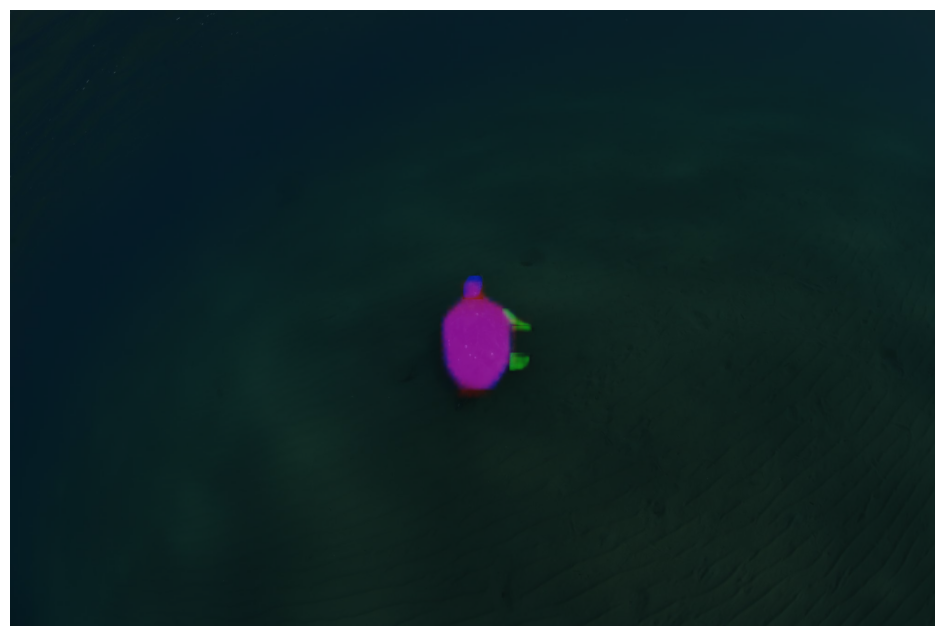

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set a confidence threshold
confidence_threshold = 0.5

# Extract data
scores = prediction['scores']
high_conf_indices = [i for i, s in enumerate(scores) if s > confidence_threshold]
if not high_conf_indices:
    print("No objects detected with confidence above the threshold.")
else:
    masks = prediction['masks'][high_conf_indices]
    labels = prediction['labels'][high_conf_indices]
    boxes = prediction['boxes'][high_conf_indices]

    # Squeeze masks and move to CPU
    masks = masks.squeeze(1).cpu().numpy()
    labels = labels.cpu().numpy()
    boxes = boxes.cpu().numpy()

    # Define class names and colors
    class_names = ['background', 'carapace', 'flipper', 'head']
    colors = {
        1: [1, 0, 0],  # Red for carapace
        2: [0, 1, 0],  # Green for flipper
        3: [0, 0, 1],  # Blue for head
    }

    # Convert image tensor to NumPy array
    image_np = image_tensor.cpu().numpy().transpose(1, 2, 0)

    # Create an empty mask for overlay
    combined_mask = np.zeros_like(image_np)

    # Overlay each mask
    for i in range(len(masks)):
        mask = masks[i]
        label = labels[i]
        color = colors.get(label, [1, 1, 1])  # Default to white if label not found

        # Create a colored mask
        colored_mask = np.zeros_like(image_np)
        for c in range(3):
            colored_mask[:, :, c] = mask * color[c]

        # Overlay the colored mask
        combined_mask = np.where(colored_mask > 0, colored_mask, combined_mask)

    # Blend the original image with the mask
    alpha = 0.5
    blended = (image_np * (1 - alpha) + combined_mask * alpha)

    # Display the result
    plt.figure(figsize=(12, 8))
    plt.imshow(blended)
    plt.axis('off')
    plt.show()
